In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import re 
from operator import itemgetter
import warnings
from scipy.integrate import solve_ivp
from scipy import optimize
import seaborn as sns
from shelllock import PyCCELL_PRFQT as px
from sklearn.metrics import r2_score
warnings.filterwarnings('ignore')
import latexify

# Model

![../images/master_eq_model.png](../images/master_eq_model.png)

In [2]:
sns.set_palette('colorblind')

In [3]:
def system(t,z,param):
    
    GC,GCT,Pa,Pi,Tc,Tu= z
    
    k1,k3,k4 = param  
    
    dGCdt = -(k1*GC*Tu) + k4 * GCT
    
    dGCTdt = - dGCdt
    
    dPadt = k3*GCT*Pi

    dPidt = -dPadt
    
    dTcdt = k4*GCT
    
    dTudt = -(k1*GC*Tu)
    
    return [dGCdt, dGCTdt, dPadt, dPidt, dTcdt, dTudt]

def error(param,obs):
    
    times = np.linspace(0,480,97) # number of time points
    
    t = np.linspace(0,500,500) # number of time point to solve 
    
    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([param]),
                    t_eval=times,method='DOP853',dense_output=True,rtol=1e-8,atol=1e-8)
    
    m = sol.sol(times)
    
    err = []
        
    for i in range(len(m.tolist()[2])): #don't forget that the [2] is because we are fitting the dPadt 
        if m.tolist()[2][i] < 1000:
            err.append((obs[i]-m.tolist()[2][i])**2)  
    
    erro = np.sum(err)

    return erro

In [4]:
targ = pd.read_csv('../results/SHERLOCK/all_targets/pos_targets.csv')
targ.head()

,Unnamed: 0,PositiveC,100nM_Trigopus,SD,Synthetic DNA,10nM_Trigopus,IL17,40s,100µM_ToxR,EF1a,...,DnaJ09,DnaJ10_f,flaA,ToxR_f,100nM_ToxR,ToxRm1,10nM_ToxR,ToxRm2,100nM_DnaJ07,10nM_DnaJ07
0,0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.090476,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,3,0.0,0.0,1.211587,0.000000,0.0,0.0,0.0,0.000000,0.526190,...,0.000000,0.0,0.0,0.660476,0.000000,0.506190,0.0,0.0,0.0,0.0
4,4,0.0,0.0,1.891746,0.507302,0.0,0.0,0.0,0.376825,1.000635,...,0.193651,0.0,0.0,1.126190,0.407937,1.189048,0.0,0.0,0.0,0.0


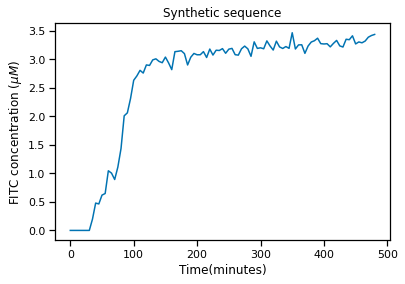

In [56]:
sns.lineplot([x*5 for x in range(len(targ.PositiveC))],targ.PositiveC)
plt.ylabel('FITC concentration ($\mu M$)')
plt.xlabel('Time(minutes)')
plt.title('Synthetic sequence')
plt.savefig('../images/SHERLOCK/POC.png',dpi=300)
plt.show()

In [6]:
#Initial conditions (concentrations in microM)
GC0 = 0.4 
GCT0 = 0.
Pa0 = 0.
Pi0 = 4.
Tc0 = 0.
Tu0 = 1

# Parameters (in /min)
k1 = 1
k3 = 0.15
k4 = 0.01


z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
param  = [k1,k3,k4]

bnds = [(0.00000001,1000000000),(0.00000001,1000000),(0,3)]
res = optimize.minimize(error, param, args=(list(targ.ToxRm1))
                        ,method='Nelder-Mead',bounds=bnds)#

In [7]:
res.x

array([0.11390562, 0.05152699, 0.01634994])

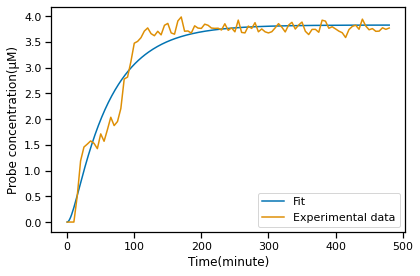

In [8]:
#times = np.linspace(0,480,97)
times = np.linspace(0,480,97*3-1)
times_exp = np.linspace(0,480,97)

sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                	t_eval=times,dense_output=True)
m = sol.sol(times)

## 
counter = 0
cleaned_m = []
for val in m[2]:
    if counter%3 == 0:
        cleaned_m.append(val)
    counter +=1
    
#r = r2_score(correct[correct.columns[1]],m[2])
r = r2_score(targ.PositiveC,cleaned_m)


sns.set_context('notebook')
#sns.set_palette("tab10")

plt.plot(times,m[2],label="Fit")
plt.errorbar(times_exp,targ.ToxRm1,label="Experimental data")#,yerr=correct['0.1nM_target_std'])
plt.xlabel('Time(minute)')
plt.ylabel('Probe concentration(µM)')
#plt.title(f'R²: {(round(r*100))}, parameters: 1/k1={round(1/res.x[0],2)} min 1/k3={round(1/res.x[1],2)} min 1/k4={round(1/res.x[2],3)}min')
plt.tight_layout()
plt.legend()
#plt.xlim(0,50)
#plt.savefig("../images/SHERLOCK/modeling/better_model.png",dpi=300)
#plt.savefig("../images/fixed_model.png",dpi=300)
plt.show()

In [9]:
param = [x for x in res.x]
param

[0.11390561850443788, 0.05152698841632133, 0.016349944218939223]

In [5]:
al = px.excelreader('../results/SHERLOCK/all_targets/220920_sherlock_v2.xlsx'
               ,75,"YES")

In [6]:
name = pd.read_csv('../results/SHERLOCK/all_targets/plan_de_plaque_3.txt',sep = "\t", header=None)
names = list(name[2].values)

names.extend(['Time'])
print(len(names))

68


In [7]:
for i in range(len(al.columns)):
    al.rename(columns={al.columns[i]:names[i]},inplace=True)
    
len(al.columns)

68

In [13]:
al['PositiveC_1']

0     4.334897
1     4.695015
2     4.941935
3     4.873314
4     4.914370
        ...   
92    9.230792
93    9.078886
94    9.133431
95    9.150440
96    9.198240
Name: PositiveC_1, Length: 97, dtype: float64

In [14]:
for i in al.columns:
    al[i] = al[i] - al['Average']
    al[al < 0] = 0
al

,PositiveC_1,PositiveC_2,PositiveC_3,ToxRm10_1,ToxRm10_2,ToxRm10_3,SD_1,SD_2,SD_3,Synthetic DNA_1,...,ToxRm4_2,ToxRm4_3,ToxRm6_1,ToxRm6_2,ToxRm6_3,ToxRm8_1,ToxRm8_2,ToxRm8_3,Average,Time
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.435875,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.735484,0.829032,1.536070,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0
4,0.000000,0.112317,0.000000,0.0,0.0,0.0,1.282405,1.425806,2.405279,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,2.654936,3.344086,3.513001,0.0,0.0,0.0,2.689247,3.414174,4.704790,4.267253,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,460.0
93,2.755034,3.486413,3.966764,0.0,0.0,0.0,2.620430,3.534506,4.974096,4.394330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,465.0
94,2.797361,3.545748,3.660997,0.0,0.0,0.0,2.742522,3.516129,5.117302,4.590616,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,470.0
95,2.636755,3.428250,3.922972,0.0,0.0,0.0,2.652590,3.617107,5.137928,4.355230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,475.0


Trying sequence PositiveC_1...


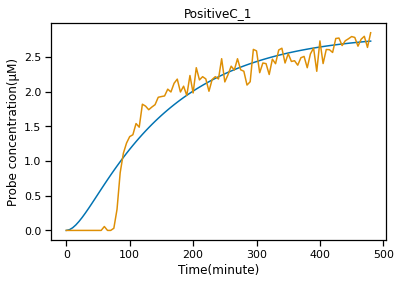

Done for PositiveC_1
---------------------------------------------------------------------
Trying sequence PositiveC_2...


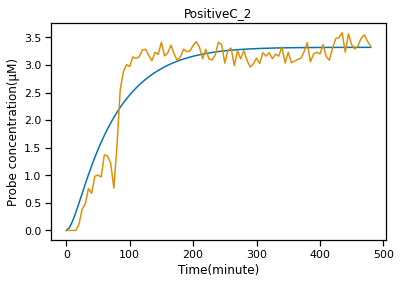

Done for PositiveC_2
---------------------------------------------------------------------
Trying sequence PositiveC_3...


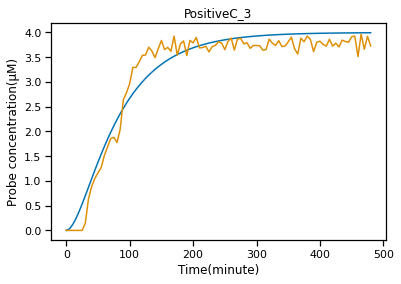

Done for PositiveC_3
---------------------------------------------------------------------
Trying sequence SD_1...


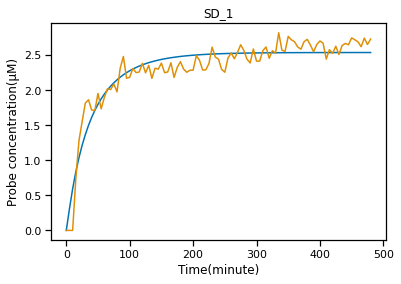

Done for SD_1
---------------------------------------------------------------------
Trying sequence SD_2...


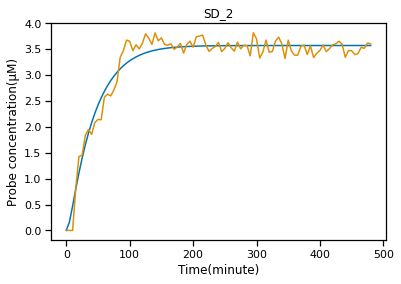

Done for SD_2
---------------------------------------------------------------------
Trying sequence SD_3...


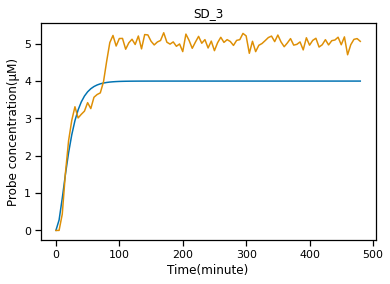

Done for SD_3
---------------------------------------------------------------------
Trying sequence Synthetic DNA_1...


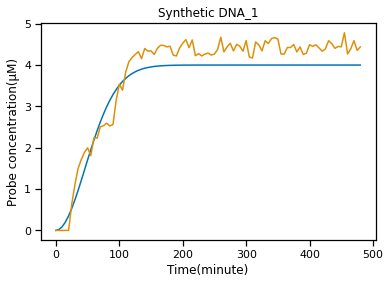

Done for Synthetic DNA_1
---------------------------------------------------------------------
Trying sequence Synthetic DNA_2...


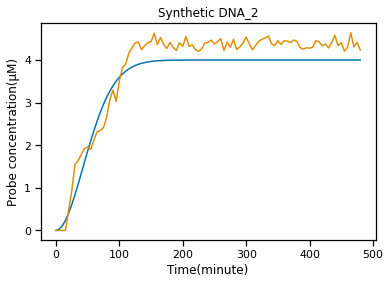

Done for Synthetic DNA_2
---------------------------------------------------------------------
Trying sequence Synthetic DNA_3...


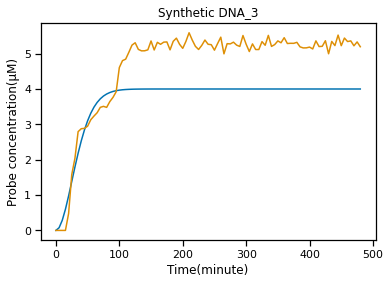

Done for Synthetic DNA_3
---------------------------------------------------------------------
Trying sequence IL17_1...


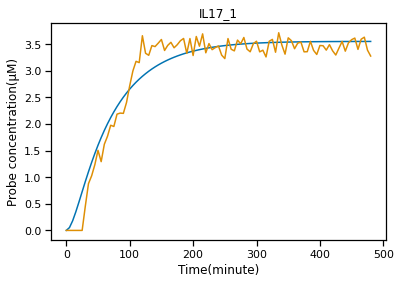

Done for IL17_1
---------------------------------------------------------------------
Trying sequence IL17_2...


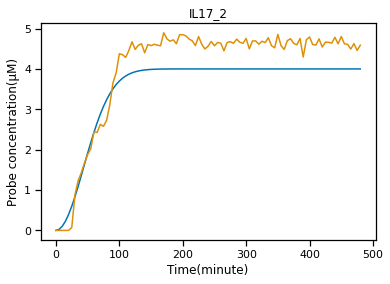

Done for IL17_2
---------------------------------------------------------------------
Trying sequence IL17_3...


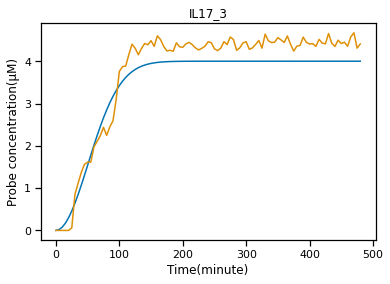

Done for IL17_3
---------------------------------------------------------------------
Trying sequence EF1a_1...


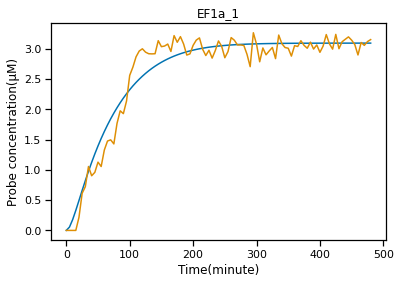

Done for EF1a_1
---------------------------------------------------------------------
Trying sequence EF1a_2...


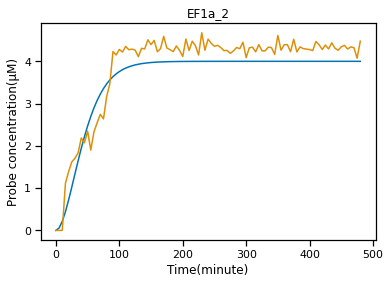

Done for EF1a_2
---------------------------------------------------------------------
Trying sequence EF1a_3...


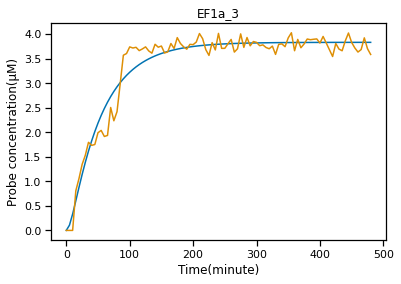

Done for EF1a_3
---------------------------------------------------------------------
Trying sequence DnaJ07_1...


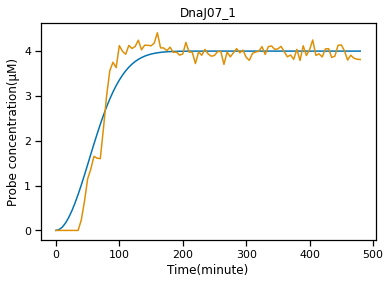

Done for DnaJ07_1
---------------------------------------------------------------------
Trying sequence DnaJ07_2...


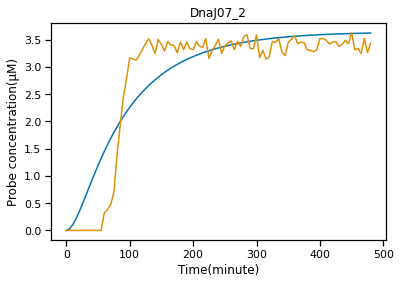

Done for DnaJ07_2
---------------------------------------------------------------------
Trying sequence DnaJ07_3...


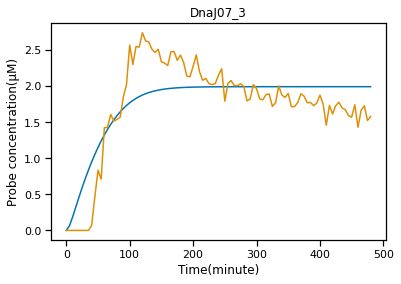

Done for DnaJ07_3
---------------------------------------------------------------------
Trying sequence Trigopus_1...


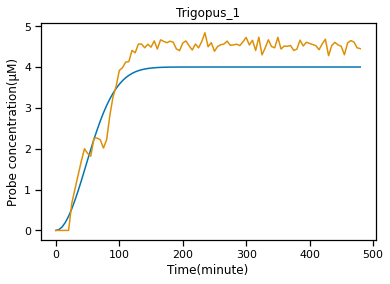

Done for Trigopus_1
---------------------------------------------------------------------
Trying sequence Trigopus_2...


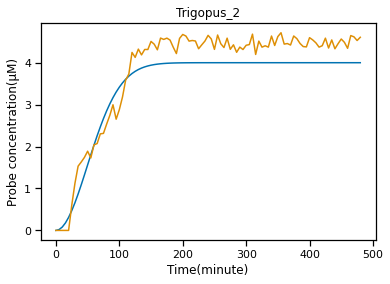

Done for Trigopus_2
---------------------------------------------------------------------
Trying sequence Trigopus_3...


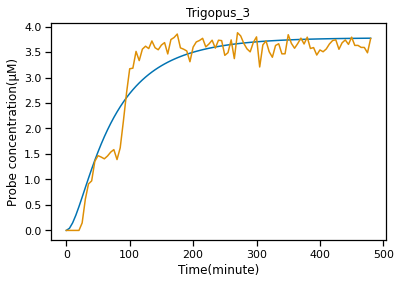

Done for Trigopus_3
---------------------------------------------------------------------
Trying sequence DnaJ09_1...


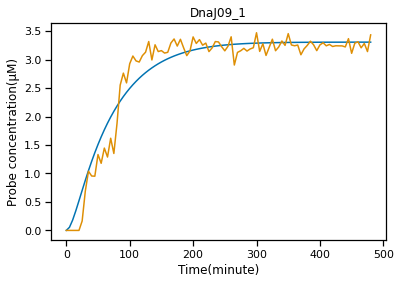

Done for DnaJ09_1
---------------------------------------------------------------------
Trying sequence DnaJ09_2...


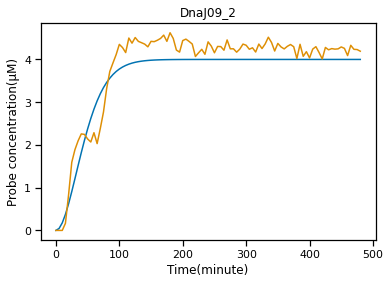

Done for DnaJ09_2
---------------------------------------------------------------------
Trying sequence DnaJ09_3...


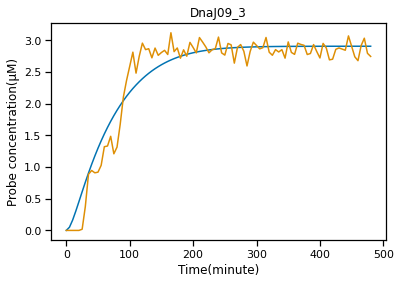

Done for DnaJ09_3
---------------------------------------------------------------------
Trying sequence DnaJ10_2...


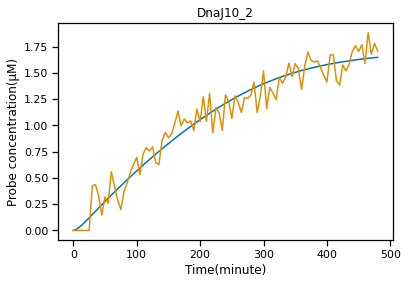

Done for DnaJ10_2
---------------------------------------------------------------------
Trying sequence DnaJ10_3...


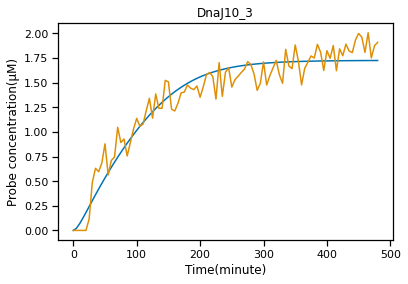

Done for DnaJ10_3
---------------------------------------------------------------------
Trying sequence flaA_1...


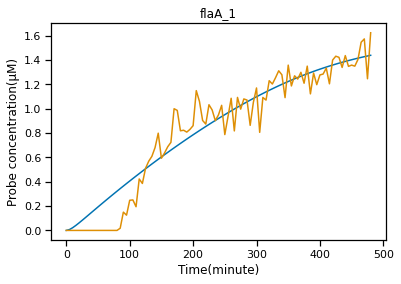

Done for flaA_1
---------------------------------------------------------------------
Trying sequence flaA_2...


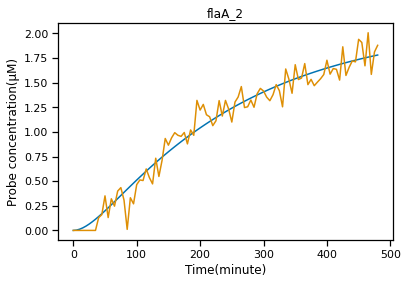

Done for flaA_2
---------------------------------------------------------------------
Trying sequence flaA_3...


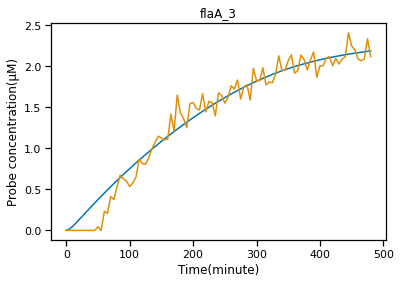

Done for flaA_3
---------------------------------------------------------------------
Trying sequence ToxR_1...


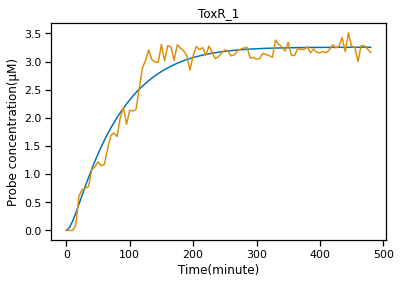

Done for ToxR_1
---------------------------------------------------------------------
Trying sequence ToxR_2...


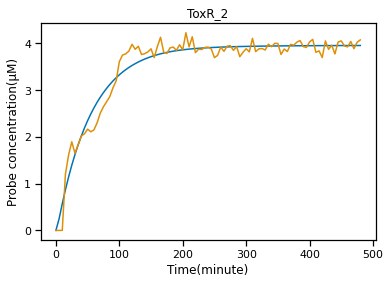

Done for ToxR_2
---------------------------------------------------------------------
Trying sequence ToxR_3...


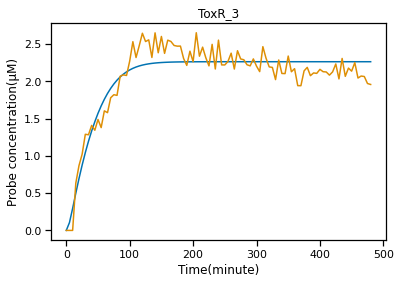

Done for ToxR_3
---------------------------------------------------------------------
Trying sequence ToxRm1_1...


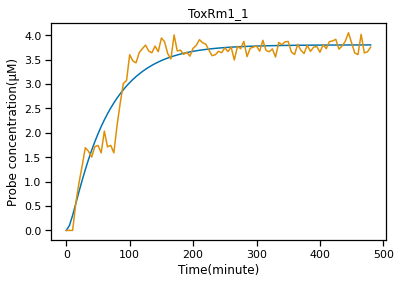

Done for ToxRm1_1
---------------------------------------------------------------------
Trying sequence ToxRm1_2...


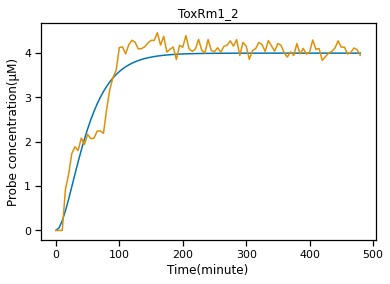

Done for ToxRm1_2
---------------------------------------------------------------------
Trying sequence ToxRm1_3...


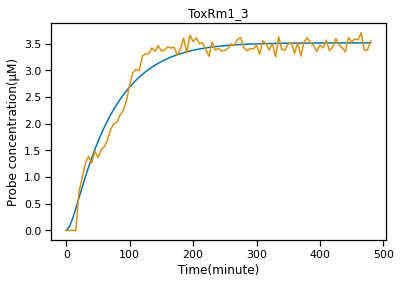

Done for ToxRm1_3
---------------------------------------------------------------------
Trying sequence ToxRm2_1...


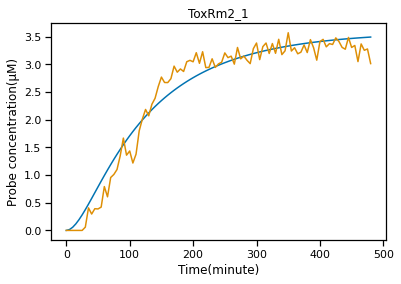

Done for ToxRm2_1
---------------------------------------------------------------------
Trying sequence ToxRm2_2...


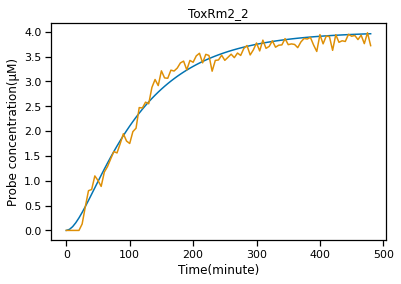

Done for ToxRm2_2
---------------------------------------------------------------------
Trying sequence ToxRm2_3...


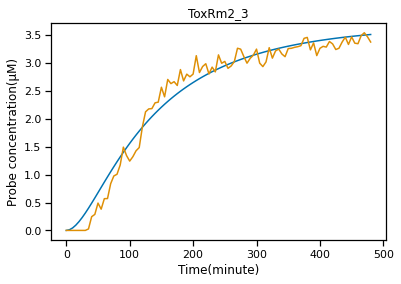

Done for ToxRm2_3
---------------------------------------------------------------------
Trying sequence Time...


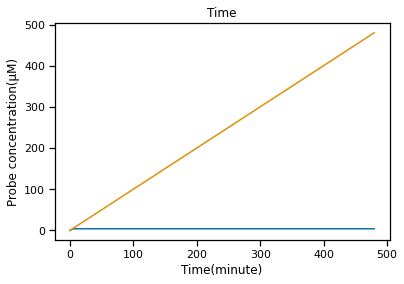

Done for Time
---------------------------------------------------------------------


In [41]:
constants_a = pd.DataFrame()
times_exp = np.linspace(0,480,97)

z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
x = [x for x in al.columns if np.max(al[x]) > 1]

for i in x:
    print('Trying sequence ' +str(i)+'...')

    z = [GC0,GCT0,Pa0,Pi0,Tc0,Tu0]
        
    #'''
    res = optimize.minimize(error, param , args=(list(al[i])),method='Nelder-Mead',bounds=bnds)
    times = np.linspace(0,480,97)

    sol = solve_ivp(system,t_span =[0, times.max()], y0= z , args =([res.x]),
                        t_eval=times,dense_output=True)
    m = sol.sol(times)
    k1,k2,k3 = res.x[0],res.x[1],res.x[2]
    
    r = r2_score(al[i],m[2])
    
    constants_a[i] = [k1,k2,k3,r]
    
    

    plt.plot(times,m[2],label="Fit")
    plt.errorbar(times_exp,al[i],label="Experimental data")
    plt.xlabel('Time(minute)')
    plt.ylabel('Probe concentration(µM)')
    plt.title(i)
    #plt.legend()
    plt.show()
    #'''
    print('Done for ' + str(i))
    print('---------------------------------------------------------------------')

constants_a = constants_a.rename({0: 'k1', 1: 'k3',2:'k4',3:'r2'}, axis='index')

In [42]:
#constants_a.to_csv('../images/SHERLOCK/modeling/constants_all_curves.csv')

In [4]:
constants_a = pd.read_csv('../images/SHERLOCK/modeling/constants_all_curves.csv')
constants_a = constants_a.drop(labels=['DnaJ10_2', 'DnaJ10_3','ToxRm1_1', 
                                       'ToxRm1_2', 'ToxRm1_3','ToxRm2_1', 'ToxRm2_2', 'ToxRm2_3'], axis=1)
#constants_a = constants_a.iloc[:, :-1]
constants_a.columns


Index(['PositiveC_1', 'PositiveC_2', 'PositiveC_3', 'SD_1', 'SD_2', 'SD_3',
       'Synthetic DNA_1', 'Synthetic DNA_2', 'Synthetic DNA_3', 'IL17_1',
       'IL17_2', 'IL17_3', 'EF1a_1', 'EF1a_2', 'EF1a_3', 'DnaJ07_1',
       'DnaJ07_2', 'DnaJ07_3', 'Trigopus_1', 'Trigopus_2', 'Trigopus_3',
       'DnaJ09_1', 'DnaJ09_2', 'DnaJ09_3', 'flaA_1', 'flaA_2', 'flaA_3',
       'ToxR_1', 'ToxR_2', 'ToxR_3', 'Time'],
      dtype='object')

In [5]:
counter = 0 
mk1 = []
mk3 = []
mk4 = []
for i in range(int((len(constants_a.columns)-1)/3)):
    mk1.append(np.mean([constants_a[constants_a.columns[counter]].iloc[0],constants_a[constants_a.columns[counter+1]].iloc[0],constants_a[constants_a.columns[counter+2]].iloc[0]]))
    mk3.append(np.mean([constants_a[constants_a.columns[counter]].iloc[1],constants_a[constants_a.columns[counter+1]].iloc[1],constants_a[constants_a.columns[counter+2]].iloc[1]]))
    mk4.append(np.mean([constants_a[constants_a.columns[counter]].iloc[2],constants_a[constants_a.columns[counter+1]].iloc[2],constants_a[constants_a.columns[counter+2]].iloc[2]]))
    counter +=3

mk = [mk1,mk3,mk4]
mk

[[0.045488261090649997,
  0.11229186612740975,
  0.007070211646300433,
  0.018871590040951368,
  0.07973461017473334,
  0.07085356756935088,
  0.012757153582647967,
  0.0588513277771249,
  0.12733698305421978,
  0.3497557294284391],
 [0.03625001517744073,
  0.9343349374944907,
  0.3431353267333061,
  5.059587939960079,
  0.07169678504408813,
  4.399510855214774,
  2.0460195605313607,
  0.08214438257058557,
  0.0073488430275711,
  0.041570233190378635],
 [0.01565404099831016,
  0.8591811432480488,
  0.0,
  0.008498406777112095,
  0.014662165876216833,
  0.020188953302981635,
  0.007441903120194666,
  0.018010963653014436,
  0.010218882696687968,
  0.02740517874009987]]

In [6]:
counter = 0 
mek1 = []
mek3 = []
mek4 = []
for i in range(int((len(constants_a.columns)-1)/3)):
    mek1.append(np.median([constants_a[constants_a.columns[counter]].iloc[0],constants_a[constants_a.columns[counter+1]].iloc[0],constants_a[constants_a.columns[counter+2]].iloc[0]]))
    mek3.append(np.median([constants_a[constants_a.columns[counter]].iloc[1],constants_a[constants_a.columns[counter+1]].iloc[1],constants_a[constants_a.columns[counter+2]].iloc[1]]))
    mek4.append(np.median([constants_a[constants_a.columns[counter]].iloc[2],constants_a[constants_a.columns[counter+1]].iloc[2],constants_a[constants_a.columns[counter+2]].iloc[2]]))
    counter +=3

mek = [mek1,mek3,mek4]
mek

[[0.0485414812557949,
  0.1042821255613167,
  0.0045183876913659,
  0.0001826157839789,
  0.0935492037696735,
  0.030052015476591,
  0.001282157624099,
  0.0710834870121745,
  0.1551761293333591,
  0.1956724508657533],
 [0.0368479300988196,
  0.172372244718544,
  0.3060538758926144,
  5.34937025602941,
  0.0596169631013914,
  0.0527370597870212,
  0.7958452055321277,
  0.0470455600695018,
  0.0058628942112983,
  0.0425350175394588],
 [0.0205387614874412,
  0.0304782930899102,
  0.0,
  1.2932474791285104e-05,
  0.0187887917557235,
  0.0217967631841928,
  0.0,
  0.0268419002039832,
  0.0067173439820653,
  0.0209761388992406]]

In [7]:
pos = [0,]
counter = 0
for i in range(1,len(constants_a.columns)-1):
    #print(i)
    if i%3 == 0:
        counter+=1
    pos.append(counter)
    
print(pos)

[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9]


In [8]:
constants_a.columns

Index(['PositiveC_1', 'PositiveC_2', 'PositiveC_3', 'SD_1', 'SD_2', 'SD_3',
       'Synthetic DNA_1', 'Synthetic DNA_2', 'Synthetic DNA_3', 'IL17_1',
       'IL17_2', 'IL17_3', 'EF1a_1', 'EF1a_2', 'EF1a_3', 'DnaJ07_1',
       'DnaJ07_2', 'DnaJ07_3', 'Trigopus_1', 'Trigopus_2', 'Trigopus_3',
       'DnaJ09_1', 'DnaJ09_2', 'DnaJ09_3', 'flaA_1', 'flaA_2', 'flaA_3',
       'ToxR_1', 'ToxR_2', 'ToxR_3', 'Time'],
      dtype='object')

In [9]:
n =['PositiveC','SD',' Synthetic' ,'IL17', 'EF1a'
     ,'DnaJ07', 'Trigopus', 'DnaJ09', 'flaA', 'ToxR']


In [10]:
sns.set_context("notebook")

0.0485414812557949


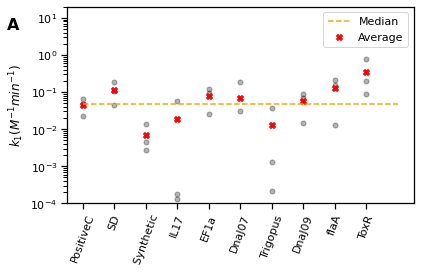

0.0596169631013914


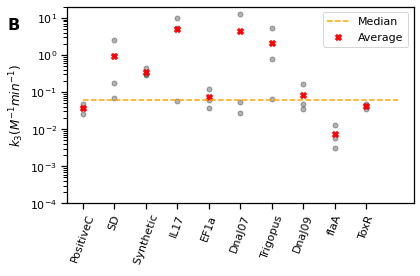

0.010215574693726


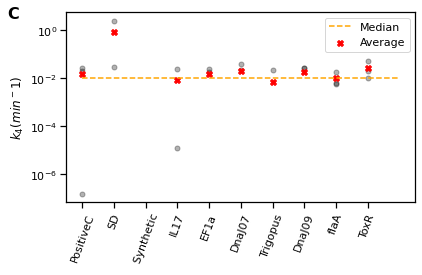

In [12]:
label =['$k_1$','$k_3$','$k_4$']
t = ['A','B','C']
for j in range(3):
    med = np.median(constants_a.iloc[j])
    print(med)
    counter = 0
    for i in constants_a.columns[:-1]:
        plt.scatter(pos[counter],constants_a[i].iloc[j],color='black',alpha=0.3,s=25)
        counter+=1

    plt.xticks(np.arange(0,10,step=1))
    plt.xticks(np.arange(10),n,rotation =70)
    #plt.hlines(np.mean(mk[j]),0,13,linestyles='dashed',label='Average')
    plt.hlines(med,0,10,linestyles='dashed',label='Median',color="orange")
    

    #plt.tight_layout()
    plt.yscale('log')
    if j ==2:
        plt.ylabel('$k_4$($min^-1$)')
    else: 
        plt.ylim(0.0001,20)
        plt.ylabel(label[j] + '($M^{-1}min^{-1}$)')
        
    plt.text(-2, 10, t[j], 
      fontsize=16, fontweight='bold', va='top', ha='right')
    plt.scatter([x for x in range(len(mk[j]))],mk[j],color ='red',marker = 'X',label='Average')
    #plt.scatter([x for x in range(len(mk[j]))],mek[j],color ='blue',marker = 'X',label="Median")
    plt.legend()
    plt.tight_layout()
    plt.savefig('../images/SHERLOCK/modeling/'+label[j].strip('$')+ '.png',dpi=300,bbox_inches = "tight")
    plt.show()

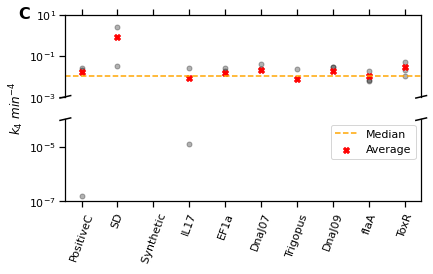

In [13]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
counter = 0
j = 2

for i in constants_a.columns[:-1]:
    ax.scatter(pos[counter],constants_a[i].iloc[j],color='black',alpha=0.3,s=25)
    ax2.scatter(pos[counter],constants_a[i].iloc[j],color='black',alpha=0.3,s=25)
    
    counter+=1
for a in [ax,ax2]:
    
    #a.axhline(np.mean(mk[j]),0,13,linestyle='dashed',label='Average')
    a.axhline(med,0,10,linestyle='dashed',label='Median',color="orange")
    a.scatter([x for x in range(len(mk[j]))],mk[j],color ='red',marker = 'X',label='Average')
    #a.scatter([x for x in range(len(mk[j]))],mek[j],color ='blue',marker = 'X',label="Median",alpha=0.5)
    
    
ax2.set_xticks(np.arange(0,10,step=1))
ax2.set_xticklabels(n,rotation =70)

ax2.set_yscale('log') 
ax.set_yscale('log') 

ax.text(-0.1, 1.1, 'C', transform=ax.transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

# zoom-in / limit the view to different portions of the data
ax2.set_ylim(0.0000001, 0.0001)  # outliers only
ax.set_ylim(0.001, 10)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'
f.text(0.0001, 0.6, '$k_4$'+' $min^{-4}$', va='center', rotation='vertical')
plt.legend()
plt.tight_layout()
plt.savefig('../images/SHERLOCK/modeling/k4_broken.png',dpi=300)
plt.show()

In [76]:
c = constants_a.loc[:,constants_a.loc['r2'] > 0.85]

c

,PositiveC_1,PositiveC_2,PositiveC_3,SD_1,SD_2,Synthetic DNA_1,Synthetic DNA_2,IL17_1,IL17_3,EF1a_1,...,flaA_3,ToxR_1,ToxR_2,ToxR_3,ToxRm1_1,ToxRm1_2,ToxRm1_3,ToxRm2_1,ToxRm2_2,ToxRm2_3
k1,0.022344,0.065579,4.854148e-02,0.045933,0.186661,0.002679,0.004518,0.056299,0.000183,0.093549,...,0.213681,0.089617,0.763977,0.195672,0.156421,0.042955,0.104943,0.020995,0.045582,0.015190
k3,0.025084,0.046818,3.684793e-02,2.562635,0.067998,0.441385,0.306054,0.055868,5.349370,0.037420,...,0.005863,0.035275,0.046901,0.042535,0.046244,0.078502,0.043041,0.039285,0.025375,0.041715
k4,0.020539,0.026423,1.556580e-07,2.547065,0.030478,0.000000,0.000000,0.025482,0.000000,0.025198,...,0.006717,0.020976,0.010216,0.051024,0.015331,0.000000,0.020320,0.017253,0.000000,0.016531
r2,0.925202,0.900109,9.513673e-01,0.903816,0.954506,0.890154,0.896296,0.946658,0.903549,0.947983,...,0.962530,0.960769,0.953402,0.878585,0.932140,0.917394,0.964102,0.959761,0.984332,0.972737


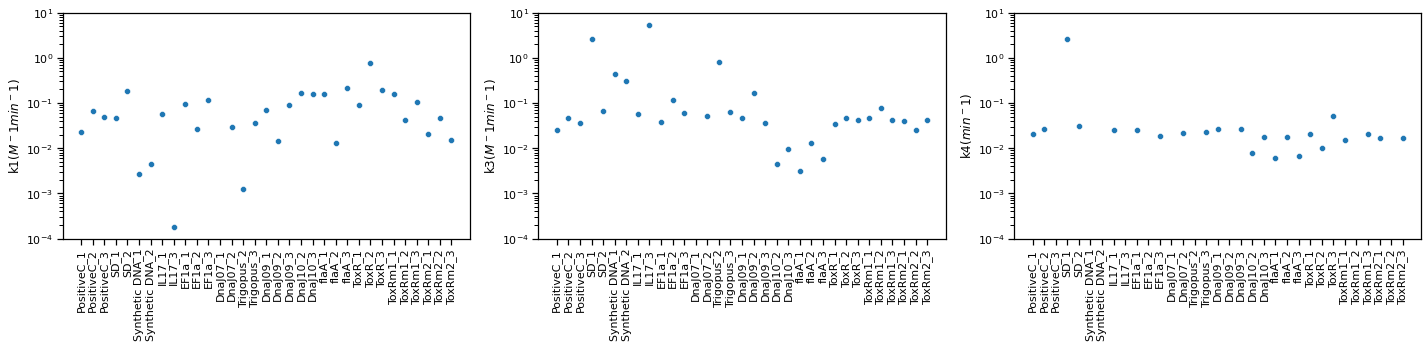

In [98]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(20,5)

counter = 0

for i in c.index:
    if i == c.index[-1]:
        break
    n = [x for x in c.loc[i].index]
    #print(np.mean(c.loc[i]))
    #print(np.std(c.loc[i]))
    sns.scatterplot([x for x in range(len(c.loc[i]))],c.loc[i],ax =ax[counter])
    
    ax[counter].set_xticks([x for x in range(len(c.loc[i]))])

    ax[counter].set_xticklabels(n,rotation=90)
    ax[counter].set_ylim(0.0001,10)
    ax[counter].set_yscale('log')
    
    
    if i != 'k4':
        ax[counter].set_ylabel(str(i)+'($M^-1min^-1$)')
    else:
        ax[counter].set_ylabel(str(i)+'($min^-1$)')
    counter+=1

plt.tight_layout()
#plt.savefig('../images/SHERLOCK/modeling/distribution_constants.png',dpi=300)
plt.show()
    

In [30]:
mk[1]

[0.03625001517744073,
 0.9343349374944907,
 0.3431353267333061,
 5.059587939960079,
 0.07169678504408813,
 4.399510855214774,
 2.0460195605313607,
 0.08214438257058557,
 0.0073488430275711,
 0.041570233190378635,
 0.0559291979025426,
 0.035458290590135166]

In [29]:
for i in mk:
    print(np.std(i))

0.08867996356045842
1.7277686537060504
0.23390986959931326


In [14]:
x = [x for x in allt.columns if "Unnamed" not in x and "_sd" not in x]


In [13]:
allt = pd.read_csv('../images/SHERLOCK/modeling/alltargets.csv')

In [15]:
allt = allt[x]
allt

,PositiveC,ToxRm10,100nM_Trigopus,SD,Synthetic DNA,10nM_Trigopus,IL17,Synthetic DNA full,1nM_Trigopus,16s03,...,10nM_ToxR,ToxRm2,1nM_ToxR,ToxRm4,100nM_DnaJ07,ToxRm6,10nM_DnaJ07,ToxRm8,1nM_DnaJ07,Time
0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0
1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,5
2,0.000000,0.0,0.000000,0.090476,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,10
3,0.000000,0.0,0.000000,1.211587,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,15
4,0.000000,0.0,0.000000,1.891746,0.507302,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,3.287937,0.0,3.384444,3.605714,4.728571,2.253651,4.076032,0.0,0.0,0.0,...,0.590635,3.334603,0.0,0.0,3.660476,0.0,0.881587,0.0,0.0,460
93,3.318413,0.0,3.360635,3.717778,4.766190,2.533968,4.216825,0.0,0.0,0.0,...,0.716508,3.484921,0.0,0.0,3.781429,0.0,0.960794,0.0,0.0,465
94,3.386190,0.0,3.363175,3.796190,4.682063,2.515873,4.196508,0.0,0.0,0.0,...,0.679365,3.590794,0.0,0.0,3.716825,0.0,1.012381,0.0,0.0,470
95,3.415873,0.0,3.493810,3.826984,4.742857,2.532857,4.264127,0.0,0.0,0.0,...,0.745556,3.536032,0.0,0.0,3.778889,0.0,1.093492,0.0,0.0,475


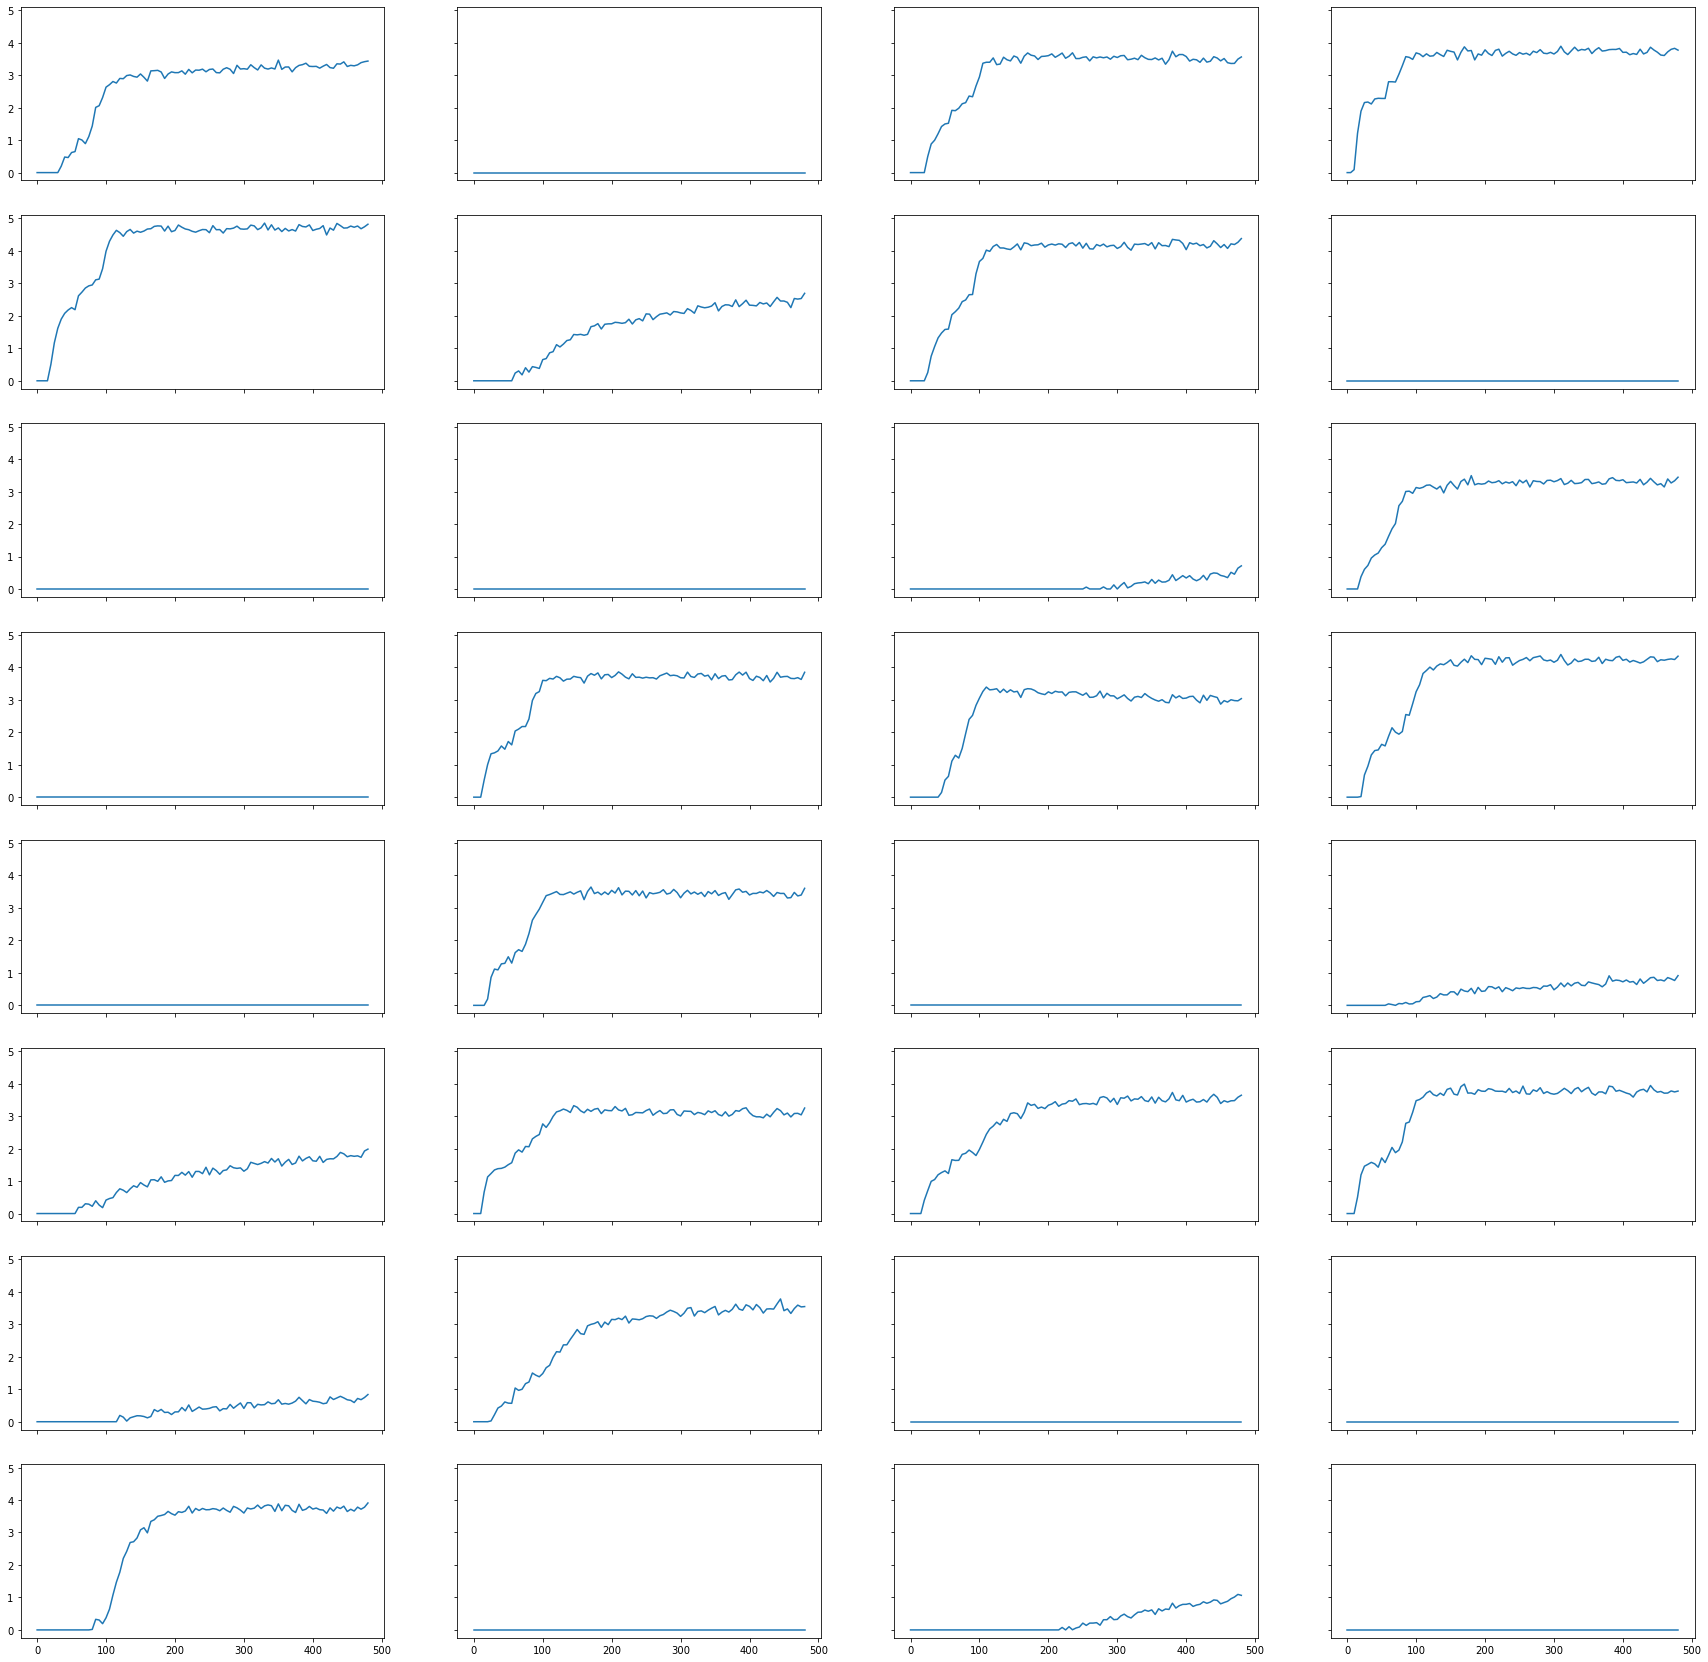

In [5]:
px.plot_raw_data(allt,8,4)
plt.savefig('../images/SHERLOCK/gridpng',dpi=300)
plt.show()

# ToxR

In [7]:
constants_a = pd.read_csv('../images/SHERLOCK/modeling/constants_all_curves.csv')
x = [ x for x in constants_a.columns if "ToxR" in x]
tox = constants_a[x]

pos = [9,10,11,12]
values = [0,0,0,0]
name =['ToxRm4','ToxRm6','ToxRm8','ToxRm10']
for i in range(len(pos)):
    tox.insert(pos[i], name[i], values)
    
tox

,ToxR_1,ToxR_2,ToxR_3,ToxRm1_1,ToxRm1_2,ToxRm1_3,ToxRm2_1,ToxRm2_2,ToxRm2_3,ToxRm4,ToxRm6,ToxRm8,ToxRm10
k1,0.089617,0.763977,0.195672,0.156421,0.042955,0.104943,0.020995,0.045582,0.015190,0,0,0,0
k3,0.035275,0.046901,0.042535,0.046244,0.078502,0.043041,0.039285,0.025375,0.041715,0,0,0,0
k4,0.020976,0.010216,0.051024,0.015331,0.000000,0.020320,0.017253,0.000000,0.016531,0,0,0,0
r2,0.960769,0.953402,0.878585,0.932140,0.917394,0.964102,0.959761,0.984332,0.972737,0,0,0,0


In [8]:
pos = [0,]
counter = 0
for i in range(1,len(tox.columns)-4):
    #print(i)
    if i%3 == 0:
        counter+=1
    pos.append(counter)
x= 3,4,5,6
for j in x:
    pos.append(j)
print(pos)

[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 4, 5, 6]


In [9]:
counter = 0 
mk1 = []
mk3 = []
mk4 = []
for i in range(int((len(tox.columns)-1)/3)):
    mk1.append(np.mean([tox[tox.columns[counter]].iloc[0],tox[tox.columns[counter+1]].iloc[0],tox[tox.columns[counter+2]].iloc[0]]))
    mk3.append(np.mean([tox[tox.columns[counter]].iloc[1],tox[tox.columns[counter+1]].iloc[1],tox[tox.columns[counter+2]].iloc[1]]))
    mk4.append(np.mean([tox[tox.columns[counter]].iloc[2],tox[tox.columns[counter+1]].iloc[2],tox[tox.columns[counter+2]].iloc[2]]))
    counter +=3

l = [0.,0.,0.]

mk = [mk1,mk3,mk4]
for h in mk:
    h.extend(l)
mk


[[0.3497557294284391,
  0.1014394106837449,
  0.027255536778859227,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.041570233190378635,
  0.0559291979025426,
  0.035458290590135166,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.02740517874009987,
  0.011883765728882468,
  0.0112615845840663,
  0.0,
  0.0,
  0.0,
  0.0]]

In [10]:
counter = 0 
mek1 = []
mek3 = []
mek4 = []
for i in range(int((len(tox.columns)-1)/3)):
    mek1.append(np.median([tox[tox.columns[counter]].iloc[0],tox[tox.columns[counter+1]].iloc[0],tox[tox.columns[counter+2]].iloc[0]]))
    mek3.append(np.median([tox[tox.columns[counter]].iloc[1],tox[tox.columns[counter+1]].iloc[1],tox[tox.columns[counter+2]].iloc[1]]))
    mek4.append(np.median([tox[tox.columns[counter]].iloc[2],tox[tox.columns[counter+1]].iloc[2],tox[tox.columns[counter+2]].iloc[2]]))
    counter +=3

mek = [mek1,mek3,mek4]

for h in mek:
    h.extend(l)
    
mek

[[0.1956724508657533,
  0.1049426126836189,
  0.0209946147134348,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0425350175394588,
  0.0462441832997862,
  0.0392854149601415,
  0.0,
  0.0,
  0.0,
  0.0],
 [0.0209761388992406,
  0.0153312043620309,
  0.0165314034823923,
  0.0,
  0.0,
  0.0,
  0.0]]

0.0429549160530332
[0.3497557294284391, 0.1014394106837449, 0.027255536778859227, 0.0, 0.0, 0.0, 0.0]


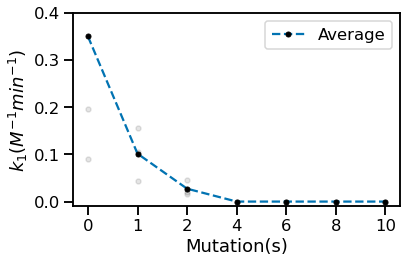

0.0392854149601415
[0.041570233190378635, 0.0559291979025426, 0.035458290590135166, 0.0, 0.0, 0.0, 0.0]


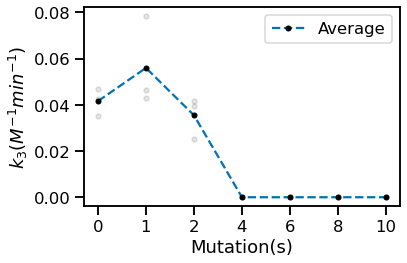

0.010215574693726
[0.02740517874009987, 0.011883765728882468, 0.0112615845840663, 0.0, 0.0, 0.0, 0.0]


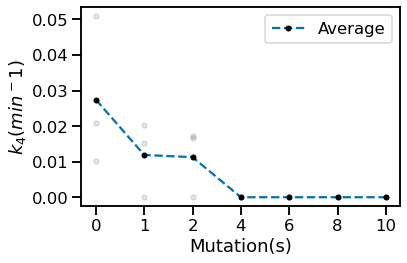

In [14]:
sns.set_context('talk')
label =['$k_1$','$k_3$','$k_4$']
t = ['A','B','C']
n = [0,1,2,4,6,8,10]
for j in range(3):
    med = np.median(tox.iloc[j])
    print(med)
    counter = 0
    for i in tox.columns:
        plt.scatter(pos[counter],tox[i].iloc[j],color='black',alpha=0.1,s=25)
        counter+=1

    plt.xticks(np.arange(0,7,step=1))
    plt.xticks(np.arange(7),n)
    #plt.hlines(np.mean(mk[j]),0,13,linestyles='dashed',label='Average')
    #plt.hlines(med,0,13,linestyles='dashed',label='Median',color="orange")
    

    #plt.tight_layout()
    #plt.yscale('log')
    if j ==2:
        plt.ylabel('$k_4$($min^-1$)')
    elif j ==0:
        plt.ylim(-0.01,0.4)
        plt.ylabel(label[j] + '($M^{-1}min^{-1}$)')
    else: 
        #plt.ylim(0.0001,20)
        plt.ylabel(label[j] + '($M^{-1}min^{-1}$)')
    plt.xlabel('Mutation(s)')   
    print(mk[j])
    '''
    if j == 0:
        plt.text(-1.2, 0.41, t[j], 
          fontsize=16, fontweight='bold', va='top', ha='right')
    else: 
        plt.text(-1.2, np.max(tox.iloc[j]), t[j], 
          fontsize=16, fontweight='bold', va='top', ha='right')
    '''
    
    plt.plot([x for x in range(len(mk[j]))],mk[j],linestyle='--',marker='o',label='Average',markersize=5
            ,markeredgecolor='black',markerfacecolor='black')
    #plt.scatter([x for x in range(len(mek[j]))],mek[j],color ='blue',marker = 'X',label="Median")
    plt.legend()
    plt.tight_layout()
    plt.savefig('../images/SHERLOCK/modeling/tox_'+label[j].strip('$')+ '_.png',dpi=300)
    plt.show()